In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import glob
import os

def read_file(file_path):
    """
    读取CSV文件。
    """
    try:
        return pd.read_csv(file_path, encoding='utf-8-sig')
    except Exception as e:
        print(f"读取文件 {file_path} 时出错: {str(e)}")
        raise

def calculate_portfolio_metrics(returns_series, rf_series, start_date='2007-01-01', end_date='2023-12-31'):
    """
    计算投资组合指标。

    参数:
    - returns_series: pd.Series，投资组合的收益率序列（已为超额收益率）
    - rf_series: pd.Series，无风险收益率序列
    - start_date: str，分析的开始日期
    - end_date: str，分析的结束日期

    返回:
    - dict，包含各项投资组合指标
    """
    try:
        # 确保索引是datetime
        returns_series = returns_series.copy()
        rf_series = rf_series.copy()
        returns_series.index = pd.to_datetime(returns_series.index)
        rf_series.index = pd.to_datetime(rf_series.index)

        # 数据过滤
        returns = returns_series.loc[start_date:end_date].astype(float)
        rf_rates = rf_series.loc[start_date:end_date].astype(float)

        if len(returns) == 0:
            print("警告：所选时间范围内没有收益率数据")
            return {k: np.nan for k in [
                'mean_monthly_return', 'annualized_return', 'monthly_std_dev', 
                'annualized_std_dev', 't_statistic', 'p_value', 
                'annualized_sharpe_ratio', 'maximum_drawdown'
            ]}

        mean_return = returns.mean()
        std_dev = returns.std()
        t_stat = (mean_return) / (std_dev / np.sqrt(len(returns))) if std_dev != 0 else np.nan
        p_value = 2 * (1 - stats.t.cdf(abs(t_stat), len(returns)-1)) if not np.isnan(t_stat) else np.nan

        annual_factor = 12
        annual_return = mean_return * annual_factor

        # 由于所有收益率都是超额收益率，直接计算夏普比率
        annual_std = std_dev * np.sqrt(annual_factor)
        sharpe_ratio = (annual_return) / annual_std if annual_std != 0 else np.nan

        # 计算最大回撤
        cumulative_returns = (1 + returns).cumprod()
        rolling_max = cumulative_returns.expanding(min_periods=1).max()
        drawdowns = (cumulative_returns - rolling_max) / rolling_max
        max_drawdown = drawdowns.min()

        return {
            'mean_monthly_return': mean_return,
            'annualized_return': annual_return,
            'monthly_std_dev': std_dev,
            'annualized_std_dev': annual_std,
            't_statistic': t_stat,
            'p_value': p_value,
            'annualized_sharpe_ratio': sharpe_ratio,
            'maximum_drawdown': max_drawdown
        }

    except Exception as e:
        print(f"计算投资组合指标时出错: {str(e)}")
        return {k: np.nan for k in [
            'mean_monthly_return', 'annualized_return', 'monthly_std_dev', 
            'annualized_std_dev', 't_statistic', 'p_value', 
            'annualized_sharpe_ratio', 'maximum_drawdown'
        ]}

def process_all_factors(data_directory, output_file, start_date='2007-01-01', end_date='2023-12-31'):
    """
    处理所有因子文件，计算各组合的指标，并汇总结果。

    参数:
    - data_directory: str，因子文件所在目录路径
    - output_file: str，结果输出文件路径
    - start_date: str，分析的开始日期
    - end_date: str，分析的结束日期

    返回:
    - pd.DataFrame，包含所有组合的指标
    """
    try:
        # 获取所有CSV文件
        all_files = glob.glob(os.path.join(data_directory, "*.csv"))

        # 定义需要计算的收益率列
        return_columns = {
            'return_long_mv': 'Long_MV',
            'return_short_mv': 'Short_MV',
            'return_spread_mv': 'Spread_MV',
            'return_long_eq': 'Long_EQ',
            'return_short_eq': 'Short_EQ',
            'return_spread_eq': 'Spread_EQ'
        }

        all_metrics = []

        for file_path in all_files:
            try:
                # 提取因子名称
                factor_name = os.path.basename(file_path).replace(".csv", "")
                print(f"\n处理因子: {factor_name}")

                # 读取因子数据
                df = read_file(file_path)

                # 确保 'year_month' 列存在
                if 'year_month' not in df.columns:
                    print(f"警告: 文件 {file_path} 中缺少 'year_month' 列")
                    continue

                # 将 'year_month' 转换为 datetime 并设置为索引
                df['year_month'] = pd.to_datetime(df['year_month'], format='%Y-%m')
                df.set_index('year_month', inplace=True)
                df.sort_index(inplace=True)

                # 提取无风险收益率列
                if 'risk_free_month' not in df.columns:
                    print(f"警告: 文件 {file_path} 中缺少 'risk_free_month' 列，默认无风险收益率为0")
                    rf_series = pd.Series([0]*len(df), index=df.index)  # 默认无风险收益率为0
                else:
                    rf_series = df['risk_free_month']

                # 遍历每个收益率列
                for return_col, return_type in return_columns.items():
                    if return_col not in df.columns:
                        print(f"警告: 文件 {file_path} 中缺少 '{return_col}' 列")
                        metrics = {
                            '因子名称': factor_name,
                            '收益类型': return_type,
                            '权重方案': 'N/A'
                        }
                        metrics.update({k: np.nan for k in [
                            '月均收益率', '年化收益率', '月度标准差', 
                            '年化标准差', 't统计量', 'p值', 
                            '年化夏普比率', '最大回撤率'
                        ]})
                        all_metrics.append(metrics)
                        continue

                    # 选择对应的权重方案
                    if 'mv' in return_col:
                        weight_scheme = '市值加权'
                    elif 'eq' in return_col:
                        weight_scheme = '等权重'
                    else:
                        weight_scheme = '未知'

                    # 获取收益率序列
                    returns_series = df[return_col]

                    # 计算指标
                    metrics = calculate_portfolio_metrics(
                        returns_series, 
                        rf_series,
                        start_date=start_date,
                        end_date=end_date
                    )

                    # 添加额外信息
                    metrics['因子名称'] = factor_name
                    metrics['收益类型'] = return_type
                    metrics['权重方案'] = weight_scheme

                    all_metrics.append(metrics)

            except Exception as e:
                print(f"处理文件 {file_path} 时出错: {str(e)}")
                continue

        if not all_metrics:
            raise ValueError("没有成功处理任何因子文件")

        # 创建结果DataFrame
        results_df = pd.DataFrame(all_metrics)

        # 定义列的顺序
        cols = ['因子名称', '收益类型', '权重方案', 
                'mean_monthly_return', 'annualized_return', 'monthly_std_dev', 
                'annualized_std_dev', 't_statistic', 'p_value', 
                'annualized_sharpe_ratio', 'maximum_drawdown']
        results_df = results_df[cols]

        # 重命名列为中文
        chinese_columns = {
            'mean_monthly_return': '月均收益率',
            'annualized_return': '年化收益率',
            'monthly_std_dev': '月度标准差',
            'annualized_std_dev': '年化标准差',
            't_statistic': 't统计量',
            'p_value': 'p值',
            'annualized_sharpe_ratio': '年化夏普比率',
            'maximum_drawdown': '最大回撤率'
        }

        results_df = results_df.rename(columns=chinese_columns)

        # 格式化百分比和小数
        percentage_cols = ['月均收益率', '年化收益率', '月度标准差', '年化标准差', '最大回撤率']
        for col in percentage_cols:
            results_df[col] = results_df[col].apply(lambda x: '{:.2%}'.format(x) if pd.notnull(x) else 'NaN')

        decimal_cols = ['年化夏普比率', 't统计量']  # 如果有其他小数格式的列，可以在此添加
        for col in decimal_cols:
            results_df[col] = results_df[col].apply(lambda x: '{:.2f}'.format(x) if pd.notnull(x) else 'NaN')

        # p值格式化
        if 'p值' in results_df.columns:
            results_df['p值'] = results_df['p值'].apply(lambda x: '{:.4f}'.format(x) if pd.notnull(x) else 'NaN')

        # 保存结果
        results_df.to_csv(output_file, index=False, encoding='utf-8-sig')

        print(f"\n所有组合的指标已保存至 {output_file}")
        return results_df

    except Exception as e:
        print(f"处理过程中出错: {str(e)}")
        raise

def main():
    # 配置参数
    data_directory = r"D:\asset management\all_indicator_returns"  # 因子文件所在目录
    output_file = r"D:\asset management\all_indicator_returns\portfolio_metrics.csv"  # 结果输出路径
    start_date = '2007-01-01'  # 分析开始日期
    end_date = '2023-12-31'    # 分析结束日期

    # 运行处理
    summary = process_all_factors(data_directory, output_file, start_date, end_date)
    print(summary)

if __name__ == "__main__":
    main()



处理因子: ami12

处理因子: ami3

处理因子: ami6

处理因子: ami9

处理因子: dfin

处理因子: droa

处理因子: esba

处理因子: esba12

处理因子: esba3

处理因子: esba6

处理因子: esba9

处理因子: me

处理因子: pps

处理因子: pps12

处理因子: pps3

处理因子: pps6

处理因子: pps9

处理因子: qsba

处理因子: qsba12

处理因子: qsba3

处理因子: qsba6

处理因子: qsba9

处理因子: rtv

处理因子: rtv12

处理因子: rtv3

处理因子: rtv6

处理因子: rtv9

所有组合的指标已保存至 D:\asset management\all_indicator_returns\portfolio_metrics.csv
      因子名称       收益类型  权重方案   月均收益率    年化收益率  月度标准差   年化标准差   t统计量      p值  \
0    ami12    Long_MV  市值加权   0.37%    4.49%  7.64%  26.48%   0.69  0.4907   
1    ami12   Short_MV  市值加权   2.17%   26.09%  9.40%  32.55%   3.26  0.0013   
2    ami12  Spread_MV  市值加权  -1.80%  -21.60%  6.36%  22.02%  -3.99  0.0001   
3    ami12    Long_EQ   等权重  -0.34%   -4.09%  8.29%  28.72%  -0.58  0.5629   
4    ami12   Short_EQ   等权重   1.21%   14.50%  9.19%  31.84%   1.85  0.0652   
..     ...        ...   ...     ...      ...    ...     ...    ...     ...   
157   rtv9   Short_MV  市值加权   1.10%   13.21%

In [5]:
import pandas as pd

# 定义文件路径
input_file = r"D:\asset management\all_indicator_returns\portfolio_metrics.csv"
output_file = r"D:\asset management\all_indicator_returns\significant_spreads.csv"

# 读取保存的指标文件
try:
    metrics_df = pd.read_csv(input_file, encoding='utf-8-sig')
    print("成功读取 portfolio_metrics.csv 文件。")
except Exception as e:
    print(f"读取文件时出错: {str(e)}")
    exit(1)

# 确保关键列存在
required_columns = ['因子名称', '收益类型', '权重方案', '年化收益率', 'p值', '年化夏普比率']
missing_columns = [col for col in required_columns if col not in metrics_df.columns]
if missing_columns:
    print(f"警告: 以下必要的列在数据中缺失: {missing_columns}")
    exit(1)

# 过滤出收益类型为 Spread_MV 和 Spread_EQ 的组合
spread_types = ['Spread_MV', 'Spread_EQ']
spread_df = metrics_df[metrics_df['收益类型'].isin(spread_types)]

# 转换相关列的数据类型
spread_df['年化收益率'] = pd.to_numeric(spread_df['年化收益率'].str.rstrip('%'), errors='coerce') / 100
spread_df['p值'] = pd.to_numeric(spread_df['p值'], errors='coerce')
spread_df['年化夏普比率'] = pd.to_numeric(spread_df['年化夏普比率'], errors='coerce')

# 设置显著性水平
significance_level = 0.1

# 筛选出 p值 < 0.1 
significant_spreads = spread_df[
    (spread_df['p值'] < significance_level)
]

# 检查是否有筛选结果
if significant_spreads.empty:
    print("没有找到在统计意义上显著且年化收益率为正的多空组合。")
else:
    print(f"筛选出 {len(significant_spreads)} 个在统计意义上显著的多空组合。")

    # 保存筛选结果到新的 CSV 文件
    try:
        significant_spreads.to_csv(output_file, index=False, encoding='utf-8-sig')
        print(f"筛选结果已保存至 {output_file}")
    except Exception as e:
        print(f"保存文件时出错: {str(e)}")


成功读取 portfolio_metrics.csv 文件。
筛选出 52 个在统计意义上显著的多空组合。
筛选结果已保存至 D:\asset management\all_indicator_returns\significant_spreads.csv


<ipython-input-5-03db932752dc>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spread_df['年化收益率'] = pd.to_numeric(spread_df['年化收益率'].str.rstrip('%'), errors='coerce') / 100
<ipython-input-5-03db932752dc>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spread_df['p值'] = pd.to_numeric(spread_df['p值'], errors='coerce')
<ipython-input-5-03db932752dc>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See th

In [6]:
import pandas as pd

# 定义文件路径
input_file = r"D:\asset management\all_indicator_returns\significant_spreads.csv"
output_file = r"D:\asset management\all_indicator_returns\filtered_significant_spreads.csv"

# 读取 CSV 文件
try:
    df = pd.read_csv(input_file, encoding='utf-8-sig')
    print("成功读取 significant_spreads.csv 文件。")
except Exception as e:
    print(f"读取文件时出错: {str(e)}")
    exit(1)

# 确保 '收益类型' 列存在
if '收益类型' not in df.columns:
    print("警告: '收益类型' 列在数据中缺失")
    exit(1)

# 删除收益类型为 'Spread_EQ' 的行
df_filtered = df[df['收益类型'] != 'Spread_EQ']

# 保存删除后的结果到新的 CSV 文件
try:
    df_filtered.to_csv(output_file, index=False, encoding='utf-8-sig')
    print(f"删除等权方案后的结果已保存至 {output_file}")
except Exception as e:
    print(f"保存文件时出错: {str(e)}")


成功读取 significant_spreads.csv 文件。
删除等权方案后的结果已保存至 D:\asset management\all_indicator_returns\filtered_significant_spreads.csv


C:\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 26174 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 33879 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 22240 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 23376 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 30456 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 20851 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Anaconda3\lib\site-

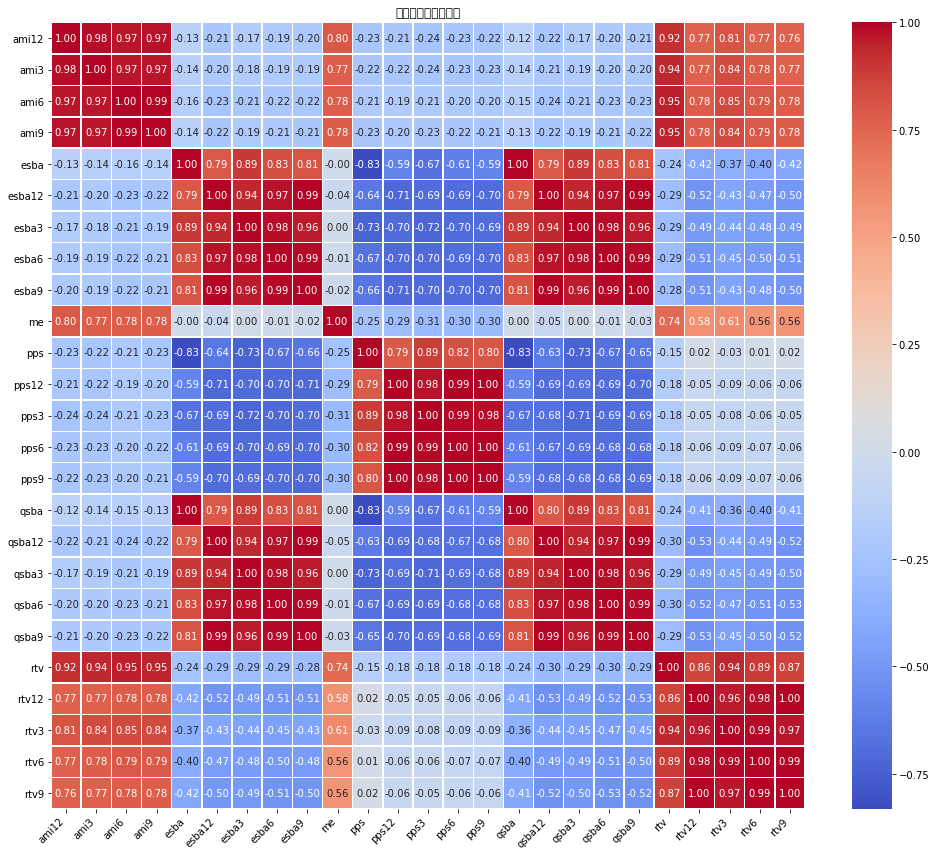

In [2]:
import pandas as pd
import glob
import os
import seaborn as sns
import matplotlib.pyplot as plt

# 1. 定义显著因子的列表
significant_factors = [
    'ami12', 'ami3', 'ami6', 'ami9',
    'esba', 'esba12', 'esba3', 'esba6', 'esba9',
    'me',
    'pps', 'pps12', 'pps3', 'pps6', 'pps9',
    'qsba', 'qsba12', 'qsba3', 'qsba6', 'qsba9',
    'rtv', 'rtv12', 'rtv3', 'rtv6', 'rtv9'
]

# 2. 读取显著因子的绩效指标
performance_metrics_path = r"D:\asset management\all_indicator_returns\filtered_significant_spreads.csv"
performance_df = pd.read_csv(performance_metrics_path)

# 确保因子名称在列表中
performance_df = performance_df[performance_df['因子名称'].isin(significant_factors)]

# 创建一个因子绩效字典，以便后续查找Sharpe Ratio
# 假设列名为 '因子名称', '年化夏普比率'
performance_dict = performance_df.set_index('因子名称')['年化夏普比率'].to_dict()

# 3. 读取并对齐显著因子的return_spread_mv数据
path = r"D:\asset management\all_indicator_returns"
spread_returns_df = pd.DataFrame()

for factor in significant_factors:
    file_path = os.path.join(path, f"{factor}.csv")
    if not os.path.exists(file_path):
        print(f"警告: 文件 {file_path} 不存在，跳过该因子。")
        continue
    
    df = pd.read_csv(file_path)
    
    # 转换year_month为datetime格式
    df['year_month'] = pd.to_datetime(df['year_month'], format='%Y-%m')
    
    # 按时间排序
    df = df.sort_values('year_month')
    
    # 设置year_month为索引
    df.set_index('year_month', inplace=True)
    
    # 提取return_spread_mv列，并重命名为因子名称
    if 'return_spread_mv' not in df.columns:
        print(f"警告: 因子 {factor} 的数据中不包含 'return_spread_mv' 列，跳过该因子。")
        continue
    
    spread_series = df['return_spread_mv'].rename(factor)
    
    # 将当前因子的spread_series与spread_returns_df按索引合并
    spread_returns_df = spread_returns_df.join(spread_series, how='outer')

# 4. 处理缺失值
# 根据需要选择一种方法，这里选择删除包含缺失值的行
spread_returns_df.dropna(inplace=True)

# 检查是否有足够的数据
if spread_returns_df.empty:
    raise ValueError("合并后的spread_returns_df为空，请检查数据源和缺失值处理方式。")

# 5. 计算相关性矩阵
correlation_matrix = spread_returns_df.corr()

# 6. 可视化相关性矩阵
plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title('显著因子相关性矩阵')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [3]:
# 7. 输出相关性矩阵到文件
correlation_matrix.to_csv(r"D:\asset management\all_indicator_returns\correlation_matrix.csv", encoding='utf-8-sig')
print("相关性矩阵已保存至 D:\\asset management\\all_indicator_returns\\correlation_matrix.csv")


相关性矩阵已保存至 D:\asset management\all_indicator_returns\correlation_matrix.csv


In [7]:
# 8. 识别相关性绝对值大于或等于0.7的因子对
threshold = 0.7
high_corr_pairs = set()

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        factor1 = correlation_matrix.columns[i]
        factor2 = correlation_matrix.columns[j]
        corr_value = correlation_matrix.iloc[i, j]
        if abs(corr_value) >= threshold:
            high_corr_pairs.add((factor1, factor2, corr_value))

print(f"\n相关系数绝对值大于或等于{threshold}的因子对:")
for pair in high_corr_pairs:
    print(f"{pair[0]} 与 {pair[1]} 的相关系数为 {pair[2]:.2f}")



相关系数绝对值大于或等于0.7的因子对:
esba3 与 esba12 的相关系数为 0.94
rtv6 与 ami6 的相关系数为 0.79
ami9 与 ami3 的相关系数为 0.97
me 与 ami9 的相关系数为 0.78
rtv12 与 ami12 的相关系数为 0.77
rtv9 与 ami9 的相关系数为 0.78
qsba6 与 esba9 的相关系数为 0.99
qsba6 与 esba12 的相关系数为 0.97
esba6 与 esba3 的相关系数为 0.98
qsba3 与 esba 的相关系数为 0.89
rtv9 与 ami12 的相关系数为 0.76
pps3 与 pps 的相关系数为 0.89
qsba3 与 esba3 的相关系数为 1.00
esba9 与 esba6 的相关系数为 0.99
qsba9 与 qsba6 的相关系数为 0.99
qsba9 与 esba9 的相关系数为 1.00
pps6 与 pps12 的相关系数为 0.99
rtv6 与 rtv12 的相关系数为 0.98
esba3 与 esba 的相关系数为 0.89
rtv9 与 ami3 的相关系数为 0.77
qsba6 与 esba 的相关系数为 0.83
qsba12 与 esba12 的相关系数为 1.00
qsba3 与 qsba 的相关系数为 0.89
qsba 与 esba6 的相关系数为 0.83
rtv6 与 ami3 的相关系数为 0.78
pps9 与 esba9 的相关系数为 -0.70
qsba9 与 esba6 的相关系数为 0.99
esba12 与 esba 的相关系数为 0.79
pps12 与 esba6 的相关系数为 -0.70
rtv 与 me 的相关系数为 0.74
qsba9 与 qsba3 的相关系数为 0.96
rtv 与 ami9 的相关系数为 0.95
qsba9 与 esba3 的相关系数为 0.96
pps3 与 esba3 的相关系数为 -0.72
rtv6 与 ami9 的相关系数为 0.79
pps3 与 esba6 的相关系数为 -0.70
ami9 与 ami6 的相关系数为 0.99
qsba3 与 esba9 的相关系数为 0.96
qsba 与 esba3 的相关系数为 0.

In [8]:
# 初始化保留因子的集合
factors_to_keep = set(spread_returns_df.columns)

for pair in high_corr_pairs:
    factor1, factor2, corr = pair
    if factor1 not in factors_to_keep or factor2 not in factors_to_keep:
        # 其中一个因子已经被剔除
        continue

    sharpe1 = performance_dict.get(factor1, None)
    sharpe2 = performance_dict.get(factor2, None)

    if sharpe1 is None or sharpe2 is None:
        print(f"警告: 因子 {factor1} 或 {factor2} 缺少年化夏普比率信息，跳过比较。")
        continue

    abs_sharpe1 = abs(sharpe1)
    abs_sharpe2 = abs(sharpe2)

    if abs_sharpe1 > abs_sharpe2:
        factors_to_keep.discard(factor2)
        print(f"剔除因子 {factor2}（年化夏普比率: {sharpe2:.2f}），保留因子 {factor1}（年化夏普比率: {sharpe1:.2f}）")
    else:
        factors_to_keep.discard(factor1)
        print(f"剔除因子 {factor1}（年化夏普比率: {sharpe1:.2f}），保留因子 {factor2}（年化夏普比率: {sharpe2:.2f}）")

print("\n最终筛选保留的因子列表：")
print(factors_to_keep)


剔除因子 esba12（年化夏普比率: 1.33），保留因子 esba3（年化夏普比率: 1.34）
剔除因子 ami6（年化夏普比率: -1.05），保留因子 rtv6（年化夏普比率: -1.45）
剔除因子 ami9（年化夏普比率: -1.03），保留因子 ami3（年化夏普比率: -1.10）
剔除因子 ami12（年化夏普比率: -0.98），保留因子 rtv12（年化夏普比率: -1.47）
剔除因子 esba9（年化夏普比率: 1.33），保留因子 qsba6（年化夏普比率: 1.38）
剔除因子 esba3（年化夏普比率: 1.34），保留因子 esba6（年化夏普比率: 1.37）
剔除因子 esba（年化夏普比率: 0.67），保留因子 qsba3（年化夏普比率: 1.35）
剔除因子 pps（年化夏普比率: -0.55），保留因子 pps3（年化夏普比率: -1.00）
剔除因子 qsba9（年化夏普比率: 1.33），保留因子 qsba6（年化夏普比率: 1.38）
剔除因子 pps12（年化夏普比率: -1.05），保留因子 pps6（年化夏普比率: -1.07）
剔除因子 rtv6（年化夏普比率: -1.45），保留因子 rtv12（年化夏普比率: -1.47）
剔除因子 ami3（年化夏普比率: -1.10），保留因子 rtv9（年化夏普比率: -1.43）
剔除因子 qsba（年化夏普比率: 0.67），保留因子 qsba3（年化夏普比率: 1.35）
剔除因子 me（年化夏普比率: -0.78），保留因子 rtv（年化夏普比率: -0.98）
剔除因子 pps3（年化夏普比率: -1.00），保留因子 esba6（年化夏普比率: 1.37）
剔除因子 qsba12（年化夏普比率: 1.34），保留因子 qsba3（年化夏普比率: 1.35）
剔除因子 rtv（年化夏普比率: -0.98），保留因子 rtv9（年化夏普比率: -1.43）
剔除因子 rtv9（年化夏普比率: -1.43），保留因子 rtv12（年化夏普比率: -1.47）
剔除因子 rtv3（年化夏普比率: -1.32），保留因子 rtv12（年化夏普比率: -1.47）
剔除因子 qsba3（年化夏普比率: 1.35），保留因子 esba6（年化夏普比率: 1.37）